# Notebook Setup

The following cell will:
- on Colab (only), install Drake to `/opt/drake`, install Drake's prerequisites via `apt`, and add pydrake to `sys.path`.  This will take approximately two minutes on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  If you navigate between notebooks using Colab's "File->Open" menu, then you can avoid provisioning a separate machine for each notebook.
- import packages used throughout the notebook.

You will need to rerun this cell if you restart the kernel, but it should be fast (even on Colab) because the machine will already have drake installed.

In [1]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='560c2adace05eb20ebd78377582015d5b2d3859a', drake_version='0.27.0', drake_build='release')

# Cart Pole Trajectory Optimization

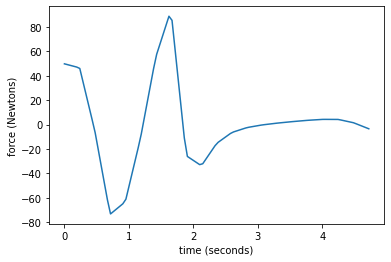

In [2]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

from pydrake.all import (DiagramBuilder, DirectCollocation, MultibodyPlant,
                         MultibodyPositionToGeometryPose, Parser,
                         PiecewisePolynomial, PlanarSceneGraphVisualizer,
                         SceneGraph, Simulator, Solve, TrajectorySource)
from underactuated import FindResource

plant = MultibodyPlant(time_step=0.0)
scene_graph = SceneGraph()
plant.RegisterAsSourceForSceneGraph(scene_graph)
file_name = FindResource("models/cartpole.urdf")
Parser(plant).AddModelFromFile(file_name)
plant.Finalize()

context = plant.CreateDefaultContext()
dircol = DirectCollocation(
    plant,
    context,
    num_time_samples=21,
    minimum_timestep=0.1,
    maximum_timestep=0.4,
    input_port_index=plant.get_actuation_input_port().get_index())

dircol.AddEqualTimeIntervalsConstraints()

initial_state = (0., 0., 0., 0.)
dircol.AddBoundingBoxConstraint(initial_state, initial_state,
                                dircol.initial_state())

final_state = (0., math.pi, 0., 0.)
dircol.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())

R = 10  # Cost on input "effort".
u = dircol.input()
dircol.AddRunningCost(R * u[0]**2)

# Add a final cost equal to the total duration.
dircol.AddFinalCost(dircol.time())

initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
    [0., 4.], np.column_stack((initial_state, final_state)))
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

result = Solve(dircol)
assert result.is_success()

fig, ax = plt.subplots()

u_trajectory = dircol.ReconstructInputTrajectory(result)
times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
u_lookup = np.vectorize(u_trajectory.value)
u_values = u_lookup(times)

ax.plot(times, u_values)
ax.set_xlabel("time (seconds)")
ax.set_ylabel("force (Newtons)");

# Animate Trajectory

<IPython.core.display.Javascript object>


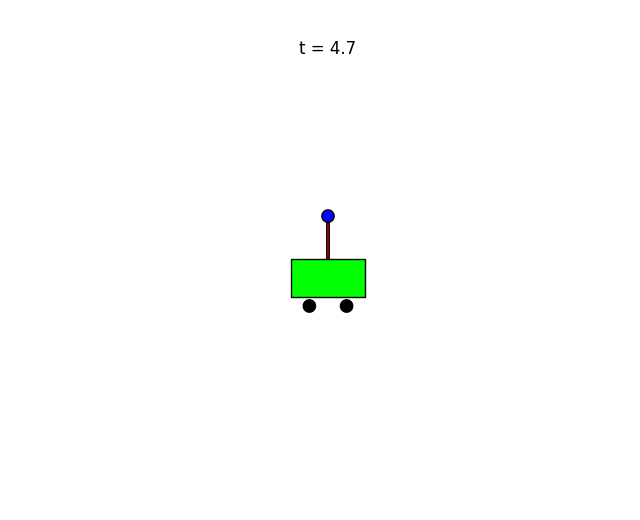

In [3]:
# Animate the results.
from IPython.display import HTML
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()

x_trajectory = dircol.ReconstructStateTrajectory(result)

builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_trajectory))
builder.AddSystem(scene_graph)
pos_to_pose = builder.AddSystem(
    MultibodyPositionToGeometryPose(plant, input_multibody_state=True))
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(),
                scene_graph.get_source_pose_port(plant.get_source_id()))

visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph,
                               xlim=[-2, 2],
                               ylim=[-1.25, 2],
                               show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))
simulator = Simulator(builder.Build())

AdvanceToAndVisualize(simulator, visualizer, x_trajectory.end_time())

# Cartpole LQR

<IPython.core.display.Javascript object>


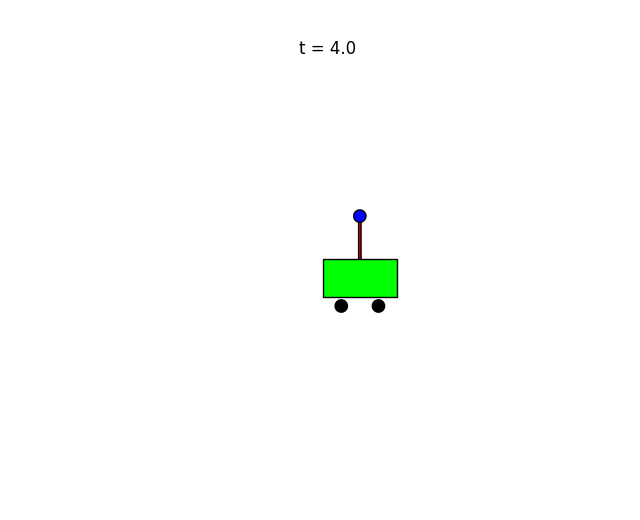

In [4]:
from pydrake.all import (
                            DiagramBuilder, LinearQuadraticRegulator, Saturation, SceneGraph, Simulator, 
                            WrapToSystem, AddMultibodyPlantSceneGraph, Parser
                        )


def cartpole_balancing_example():
    def UprightState():
        state = (0, np.pi, 0, 0)
        return state


    def BalancingLQR(plant):
        # Design an LQR controller for stabilizing the CartPole around the upright.
        # Returns a (static) AffineSystem that implements the controller (in
        # the original CartPole coordinates).

        context = plant.CreateDefaultContext()
        plant.get_actuation_input_port().FixValue(context, [0])

        context.get_mutable_continuous_state_vector().SetFromVector(UprightState())

        Q = np.diag((10., 10., 1., 1.))
        R = [1]

        # MultibodyPlant has many (optional) input ports, so we must pass the
        # input_port_index to LQR.
        return LinearQuadraticRegulator(
            plant,
            context,
            Q,
            R,
            input_port_index=plant.get_actuation_input_port().get_index())


    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    file_name = FindResource("models/cartpole.urdf")
    Parser(plant).AddModelFromFile(file_name)
    plant.Finalize()

    controller = builder.AddSystem(BalancingLQR(plant))
    builder.Connect(plant.get_state_output_port(), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0),
                    plant.get_actuation_input_port())

    # Setup visualization
    visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph,
                               xlim=[-2, 2],
                               ylim=[-1.25, 2],
                               show=plt_is_interactive))
    builder.Connect(scene_graph.get_pose_bundle_output_port(),
                    visualizer.get_input_port(0))

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0)
    context = simulator.get_mutable_context()

    # Simulate
    duration = 4.0
    for i in range(5):
        context.SetTime(0.)
        context.SetContinuousState(UprightState() + 0.1 * np.random.randn(4,))
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        AdvanceToAndVisualize(simulator, visualizer, duration)

cartpole_balancing_example()

# Next Steps
Feel Free to experiments in the cells below or edit the cells above